In [ ]:
pip install smolagents yfinance prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.2/138.2 kB 5.3 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from smolagents import CodeAgent, ToolCallingAgent
from transformers import pipeline
from prophet import Prophet

In [ ]:
# Any asset

# Define the agent for fetching asset data
class AssetDataAgent(CodeAgent):
    def __init__(self, asset_ticker):
        self.asset_ticker = asset_ticker


    def run(self):
        # Fetch asset data using yfinance
        asset_data = yf.Ticker(self.asset_ticker)
        return asset_data

# Define the agent for generating financial report
class FinancialReportAgent(CodeAgent):
    def __init__(self, asset_data):
        self.asset_data = asset_data

    def run(self):
        # Generate financial report
        info = self.asset_data.info
        report = f"# Financial Report for {info['shortName']}\n\n"
        report += f"**Sector:** {info.get('sector', 'N/A')}\n\n"
        report += f"**Industry:** {info.get('industry', 'N/A')}\n\n"
        report += f"**Market Cap:** {info.get('marketCap', 'N/A')}\n\n"
        report += f"**52 Week High:** {info.get('fiftyTwoWeekHigh', 'N/A')}\n\n"
        report += f"**52 Week Low:** {info.get('fiftyTwoWeekLow', 'N/A')}\n\n"
        return report

# Define the agent for generating trend charts
class TrendChartAgent(CodeAgent):
    def __init__(self, asset_data, start_date, end_date, purchase_price, forecast):
        self.asset_data = asset_data
        self.start_date = start_date
        self.end_date = end_date
        self.purchase_price = purchase_price
        self.forecast = forecast

    def run(self):
        # Generate trend charts
        hist = self.asset_data.history(start=self.start_date, end=self.end_date)
        plt.figure(figsize=(10, 5))
        plt.plot(hist.index, hist['Close'], label='Close Price')
        plt.axhline(y=self.purchase_price, color='r', linestyle='--', label='Purchase Price')
        plt.plot(self.forecast['ds'], self.forecast['yhat'], label='Forecast', linestyle='--', color='g')
        plt.title('Asset Price Trend')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.savefig('trend_chart.png')
        return "!Trend Chart"

# Define the agent for generating financial overview
class FinancialOverviewAgent(CodeAgent):
    def __init__(self, asset_data):
        self.asset_data = asset_data

    def run(self):
        # Generate financial overview
        financials = self.asset_data.financials if hasattr(self.asset_data, 'financials') else pd.DataFrame()
        overview = f"# Financial Overview for {self.asset_data.info['shortName']}\n\n"
        overview += financials.to_markdown() if not financials.empty else "No financial data available."
        return overview

# Define the agent for generating narrative using LLM
class FinancialNarrativeAgent(CodeAgent):
    def __init__(self, financial_overview):
        self.financial_overview = financial_overview
        self.model = pipeline("text2text-generation", model="google/flan-t5-large")

    def run(self):
        # Generate narrative using LLM
        prompt = f"Generate a narrative describing the most relevant items of the financial overview:\n\n{self.financial_overview}"
        narrative = self.model(prompt, max_length=500)[0]['generated_text']
        return narrative

# Define the agent for providing investment status
class InvestmentStatusAgent(CodeAgent):
    def __init__(self, asset_data, purchase_price, purchase_date):
        self.asset_data = asset_data
        self.purchase_price = purchase_price
        self.purchase_date = purchase_date

    def run(self):
        # Fetch historical data from the purchase date to today
        hist = self.asset_data.history(start=self.purchase_date)

        # Find the closest date in the historical data to the purchase date
        closest_date = hist.index[hist.index.get_loc(self.purchase_date, method='nearest')]

        # Get the closing price on the closest date and today
        purchase_close_price = hist.loc[closest_date]['Close']
        current_close_price = hist['Close'].iloc[-1]

        # Calculate investment status
        investment_status = current_close_price - self.purchase_price

        status_report = f"# Investment Status\n\n"
        status_report += f"**Purchase Date (approximate):** {closest_date.strftime('%Y-%m-%d')}\n\n"
        status_report += f"**Purchase Price:** {self.purchase_price}\n\n"
        status_report += f"**Current Price:** {current_close_price}\n\n"

        if investment_status > 0:
            status_report += f"**Status:** Profit of {investment_status:.2f} per unit\n\n"
        else:
            status_report += f"**Status:** Loss of {abs(investment_status):.2f} per unit\n\n"

        return status_report

# Define the agent for forecasting future prices using Prophet
class ForecastingAgent(CodeAgent):
    def __init__(self, asset_data, start_date, end_date):
        self.asset_data = asset_data
        self.start_date = start_date
        self.end_date = end_date

    def run(self):
        # Generate forecast forward of 10% of historical data length using Prophet
        hist = self.asset_data.history(start=self.start_date, end=self.end_date)

        # Prepare data for Prophet model
        df = hist.reset_index()[['Date', 'Close']]
        df.columns = ['ds', 'y']

        # Remove timezone information from 'ds' column
        df['ds'] = df['ds'].dt.tz_localize(None)

        # Calculate forecast period (10% of historical data length)
        forecast_period = int(len(df) * 0.1)

        # Fit model and generate forecast
        model = Prophet()
        model.fit(df)

        future_dates = model.make_future_dataframe(periods=forecast_period)
        forecast = model.predict(future_dates)

        return forecast[['ds', 'yhat']]

# Define the multi-agent system
class FinancialReportMultiAgent(ToolCallingAgent):
    def __init__(self, asset_ticker, start_date, end_date, purchase_price, purchase_date):
        self.asset_ticker = asset_ticker
        self.start_date = start_date
        self.end_date = end_date
        self.purchase_price = purchase_price
        self.purchase_date = purchase_date

    def run(self):
        # Create agents
        asset_data_agent = AssetDataAgent(self.asset_ticker)
        asset_data = asset_data_agent.run()

        financial_report_agent = FinancialReportAgent(asset_data)
        financial_report = financial_report_agent.run()

        forecasting_agent = ForecastingAgent(asset_data, self.start_date, self.end_date)
        forecast = forecasting_agent.run()

        trend_chart_agent = TrendChartAgent(asset_data, self.start_date, self.end_date, self.purchase_price, forecast)
        trend_chart = trend_chart_agent.run()

        financial_overview_agent = FinancialOverviewAgent(asset_data)
        financial_overview = financial_overview_agent.run()

        financial_narrative_agent = FinancialNarrativeAgent(financial_overview)
        financial_narrative = financial_narrative_agent.run()

        investment_status_agent = InvestmentStatusAgent(asset_data, self.purchase_price, self.purchase_date)
        investment_status = investment_status_agent.run()

        # Combine results
        report = financial_report + "\n\n" + trend_chart + "\n\n" + financial_overview + "\n\n" + financial_narrative + "\n\n" + investment_status
        return report

In [ ]:
# Receive human input for asset ticker, date range, and investment details
asset_ticker = input("Enter the asset ticker: ")
start_date = input("Enter the start date (YYYY-MM-DD): ")
end_date = input("Enter the end date (YYYY-MM-DD): ")
purchase_price = float(input("Enter the purchase price: "))
purchase_date = input("Enter the purchase date (YYYY-MM-DD): ")

Enter the asset ticker: MSFT
Enter the start date (YYYY-MM-DD): 2022-01-01
Enter the end date (YYYY-MM-DD): 2025-07-01
Enter the purchase price: 35.36
Enter the purchase date (YYYY-MM-DD): 2024-04-05


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuhwbu_d5/pqmq86i7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuhwbu_d5/p75xdt90.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63910', 'data', 'file=/tmp/tmpuhwbu_d5/pqmq86i7.json', 'init=/tmp/tmpuhwbu_d5/p75xdt90.json', 'output', 'file=/tmp/tmpuhwbu_d5/prophet_modelakmmkj7t/prophet_model-20250703203042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:30:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:30:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Device set to use cuda:0
Token indices sequence length is longer than the specified maximum sequence length for this model (1728 > 512). Runni

# Financial Report for Microsoft Corporation

**Sector:** Technology

**Industry:** Software - Infrastructure

**Market Cap:** 3707648344064

**52 Week High:** 500.76

**52 Week Low:** 344.79



!Trend Chart

# Financial Overview for Microsoft Corporation

|                                                            |   2024-06-30 00:00:00 |   2023-06-30 00:00:00 |   2022-06-30 00:00:00 |   2021-06-30 00:00:00 |
|:-----------------------------------------------------------|----------------------:|----------------------:|----------------------:|----------------------:|
| Tax Effect Of Unusual Items                                |          -9.9918e+07  |          -2.85e+06    |           4.3754e+07  |           1.80161e+08 |
| Tax Rate For Calcs                                         |           0.182       |           0.19        |           0.131       |           0.138266    |
| Normalized EBITDA                                          |           1.33558e+11 |           1.05155e+1

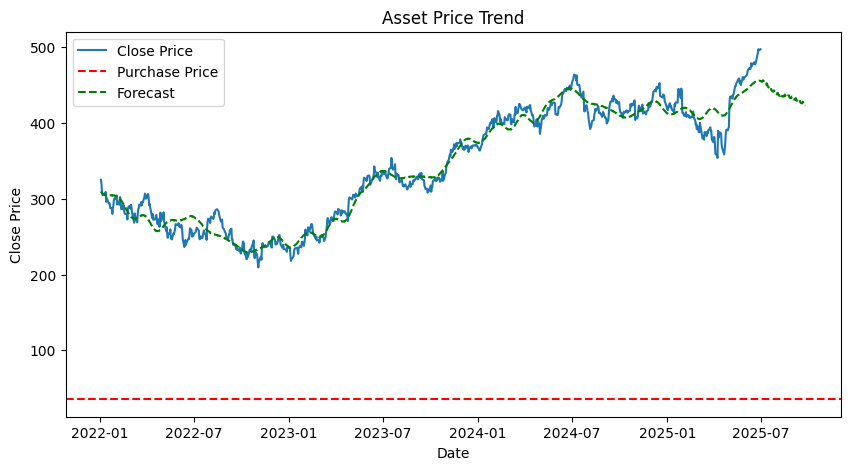

In [ ]:
# Create and run the multi-agent system
multi_agent_system = FinancialReportMultiAgent(asset_ticker, start_date, end_date, purchase_price, purchase_date)
report = multi_agent_system.run()

# Output the report in markdown format
print(report)

In [ ]:
from IPython.display import Markdown
Markdown(report)

# Financial Report for Microsoft Corporation

**Sector:** Technology

**Industry:** Software - Infrastructure

**Market Cap:** 3707648344064

**52 Week High:** 500.76

**52 Week Low:** 344.79



!Trend Chart

# Financial Overview for Microsoft Corporation

|                                                            |   2024-06-30 00:00:00 |   2023-06-30 00:00:00 |   2022-06-30 00:00:00 |   2021-06-30 00:00:00 |
|:-----------------------------------------------------------|----------------------:|----------------------:|----------------------:|----------------------:|
| Tax Effect Of Unusual Items                                |          -9.9918e+07  |          -2.85e+06    |           4.3754e+07  |           1.80161e+08 |
| Tax Rate For Calcs                                         |           0.182       |           0.19        |           0.131       |           0.138266    |
| Normalized EBITDA                                          |           1.33558e+11 |           1.05155e+11 |           9.9905e+10  |           8.3831e+10  |
| Total Unusual Items                                        |          -5.49e+08    |          -1.5e+07     |           3.34e+08    |           1.303e+09   |
| Total Unusual Items Excluding Goodwill                     |          -5.49e+08    |          -1.5e+07     |           3.34e+08    |           1.303e+09   |
| Net Income From Continuing Operation Net Minority Interest |           8.8136e+10  |           7.2361e+10  |           7.2738e+10  |           6.1271e+10  |
| Reconciled Depreciation                                    |           2.2287e+10  |           1.3861e+10  |           1.446e+10   |           1.1686e+10  |
| Reconciled Cost Of Revenue                                 |           7.4114e+10  |           6.5863e+10  |           6.265e+10   |           5.2232e+10  |
| EBITDA                                                     |           1.33009e+11 |           1.0514e+11  |           1.00239e+11 |           8.5134e+10  |
| EBIT                                                       |           1.10722e+11 |           9.1279e+10  |           8.5779e+10  |           7.3448e+10  |
| Net Interest Income                                        |           2.22e+08    |           1.026e+09   |           3.1e+07     |          -2.15e+08    |
| Interest Expense                                           |           2.935e+09   |           1.968e+09   |           2.063e+09   |           2.346e+09   |
| Interest Income                                            |           3.157e+09   |           2.994e+09   |           2.094e+09   |           2.131e+09   |
| Normalized Income                                          |           8.85851e+10 |           7.23732e+10 |           7.24478e+10 |           6.01482e+10 |
| Net Income From Continuing And Discontinued Operation      |           8.8136e+10  |           7.2361e+10  |           7.2738e+10  |           6.1271e+10  |
| Total Expenses                                             |           1.35689e+11 |           1.23392e+11 |           1.14887e+11 |           9.8172e+10  |
| Total Operating Income As Reported                         |           1.09433e+11 |           8.8523e+10  |           8.3383e+10  |           6.9916e+10  |
| Diluted Average Shares                                     |           7.469e+09   |           7.472e+09   |           7.54e+09    |           7.608e+09   |
| Basic Average Shares                                       |           7.431e+09   |           7.446e+09   |           7.496e+09   |           7.547e+09   |
| Diluted EPS                                                |          11.8         |           9.68        |           9.65        |           8.05        |
| Basic EPS                                                  |          11.86        |           9.72        |           9.7         |           8.12        |
| Diluted NI Availto Com Stockholders                        |           8.8136e+10  |           7.2361e+10  |           7.2738e+10  |           6.1271e+10  |
| Net Income Common Stockholders                             |           8.8136e+10  |           7.2361e+10  |           7.2738e+10  |           6.1271e+10  |
| Net Income                                                 |           8.8136e+10  |           7.2361e+10  |           7.2738e+10  |           6.1271e+10  |
| Net Income Including Noncontrolling Interests              |           8.8136e+10  |           7.2361e+10  |           7.2738e+10  |           6.1271e+10  |
| Net Income Continuous Operations                           |           8.8136e+10  |           7.2361e+10  |           7.2738e+10  |           6.1271e+10  |
| Tax Provision                                              |           1.9651e+10  |           1.695e+10   |           1.0978e+10  |           9.831e+09   |
| Pretax Income                                              |           1.07787e+11 |           8.9311e+10  |           8.3716e+10  |           7.1102e+10  |
| Other Income Expense                                       |          -1.868e+09   |          -2.38e+08    |           3.02e+08    |           1.401e+09   |
| Other Non Operating Income Expenses                        |          -1.319e+09   |          -2.23e+08    |          -3.2e+07     |           9.8e+07     |
| Special Income Charges                                     |          -2.06e+08    |          -3e+07       |          -1.01e+08    |          -1.3e+07     |
| Write Off                                                  |           2.06e+08    |           3e+07       |           1.01e+08    |           1.3e+07     |
| Gain On Sale Of Security                                   |          -3.43e+08    |           1.5e+07     |           4.35e+08    |           1.316e+09   |
| Net Non Operating Interest Income Expense                  |           2.22e+08    |           1.026e+09   |           3.1e+07     |          -2.15e+08    |
| Interest Expense Non Operating                             |           2.935e+09   |           1.968e+09   |           2.063e+09   |           2.346e+09   |
| Interest Income Non Operating                              |           3.157e+09   |           2.994e+09   |           2.094e+09   |           2.131e+09   |
| Operating Income                                           |           1.09433e+11 |           8.8523e+10  |           8.3383e+10  |           6.9916e+10  |
| Operating Expense                                          |           6.1575e+10  |           5.7529e+10  |           5.2237e+10  |           4.594e+10   |
| Research And Development                                   |           2.951e+10   |           2.7195e+10  |           2.4512e+10  |           2.0716e+10  |
| Selling General And Administration                         |           3.2065e+10  |           3.0334e+10  |           2.7725e+10  |           2.5224e+10  |
| Selling And Marketing Expense                              |           2.4456e+10  |           2.2759e+10  |           2.1825e+10  |           2.0117e+10  |
| General And Administrative Expense                         |           7.609e+09   |           7.575e+09   |           5.9e+09     |           5.107e+09   |
| Other Gand A                                               |           7.609e+09   |           7.575e+09   |           5.9e+09     |           5.107e+09   |
| Gross Profit                                               |           1.71008e+11 |           1.46052e+11 |           1.3562e+11  |           1.15856e+11 |
| Cost Of Revenue                                            |           7.4114e+10  |           6.5863e+10  |           6.265e+10   |           5.2232e+10  |
| Total Revenue                                              |           2.45122e+11 |           2.11915e+11 |           1.9827e+11  |           1.68088e+11 |
| Operating Revenue                                          |           2.45122e+11 |           2.11915e+11 |           1.9827e+11  |           1.68088e+11 |

During the three months ended June 30, the company reported a net income of $8.8136e+10, a net income from continuing operations of $7.2361e+10, a net income from discontinued operations of $7.2738e+10, and a net income from continuing and discontinued operations of $8.8136e+10, a net income from continuing operations of $7.2361e+10, a net income from discontinued operations of $7.2738e+10, and a net income from continuing and discontinued operations of $8.8136e+10, a net income from continuing operations of $7.2361e+10, a net income from discontinued operations of $7.2738e+10, and a net income from continuing and discontinued operations of $8.8136e+10, a net income from continuing operations of $7.2361e+10, a net income from discontinued operations of $7.2738e+10, and a net income from continuing and discontinued operations of $8.8136e+10, a net income from continuing operations of $7.2361e+10, a net income from discontinued operations of $7.2738

# Investment Status

**Purchase Date:** 2024-04-05

**Purchase Price:** 35.36

**Current Price:** 402.8392639160156

**Status:** Profit of 367.4792639160156 per unit

